In [ ]:
# 04/20 TODO: make the new 

In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from pprint import pprint
import itertools
from scipy import stats
from matplotlib.cbook import boxplot_stats
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
import sklearn.linear_model as linear_model
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# import matplotlib
# matplotlib.use('Agg')

/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### READ

In [3]:
subjs = ['1001', '1002', '1003', '1004', '1005', '1007', '1009',
         '1013', '1015', '1020', '1022', '1023', 'PP', 'MM', 'FR', 'KT', 'JD']

In [4]:
updated = pd.read_csv("/Users/darenma/Downloads/UpdatedDemographics.csv")
aif_new = updated[['ATLaS_ID', 'Age', 'Sex', 'NET dose (mCi)', 'Height (Feet, inches)', 'Weight (Kgs)', "Genotype"]].iloc[:17].copy()
new_target = pd.read_csv("../Interpolate_0203_slinear.csv")
new_y = np.array(new_target.sum().T[2:])

In [5]:
df = aif_new.copy()
df.head()

,ATLaS_ID,Age,Sex,NET dose (mCi),"Height (Feet, inches)",Weight (Kgs),Genotype
0,1001,68.0,1.0,16.09,5'7'',81.646627,2.0
1,1002,59.0,1.0,14.36,5'10'',81.646627,2.0
2,1003,63.0,1.0,12.86,6',81.646627,1.0
3,1004,71.0,1.0,13.37,5'9'',65.770894,2.0
4,1005,62.0,1.0,13.50,5'10'',56.245454,2.0


In [6]:
df.columns = ['ATLaS_ID', 'Age', 'Sex', 'Dose', 'Height',
       'Weight', 'Genotype']
df.loc[:, "auc"] = new_y

In [7]:
# Convert height into meters
df.loc[:, "feet"] = df.Height.str.split("'").str[0].astype(int)
df.loc[:, "inch"] = df.Height.str.split("'").str[1].replace("","0").str.split(".").str[0].astype(int)
df.loc[:, "meters"] = 0.3048*df.feet + 0.0254*df.inch

In [8]:
# Method 1: With BV ratios
df.loc[:, "IBW"] = (df.meters**2)*22
df.loc[(df.Sex==1), "BV/kg"] = 75
df.loc[(df.Sex==0), "BV/kg"] = 65
# df[df.Sex!=1].loc[:, "BV/kg"] = 65

df.loc[:, "TBV"] = df["BV/kg"]*df["IBW"]
df.loc[:, "Dose/TBV"] = df["Dose"]/df["TBV"]

In [9]:
df

,ATLaS_ID,Age,Sex,Dose,Height,Weight,Genotype,auc,feet,inch,meters,IBW,BV/kg,TBV,Dose/TBV
0,1001,68.0,1.0,16.09,5'7'',81.646627,2.0,1131.903507,5,7,1.7018,63.714711,75.0,4778.603346,0.003367
1,1002,59.0,1.0,14.36,5'10'',81.646627,2.0,960.628952,5,10,1.7780,69.548248,75.0,5216.118600,0.002753
2,1003,63.0,1.0,12.86,6',81.646627,1.0,446.101610,6,0,1.8288,73.579208,75.0,5518.440576,0.002330
3,1004,71.0,1.0,13.37,5'9'',65.770894,2.0,857.586570,5,9,1.7526,67.575349,75.0,5068.151154,0.002638
4,1005,62.0,1.0,13.50,5'10'',56.245454,2.0,1206.387196,5,10,1.7780,69.548248,75.0,5216.118600,0.002588
5,1007,62.0,1.0,14.86,6',131.541787,2.0,670.036776,6,0,1.8288,73.579208,75.0,5518.440576,0.002693
6,1009,55.0,0.0,11.15,5'3'',55.338269,1.0,857.640765,5,3,1.6002,56.334081,65.0,3661.715257,0.003045
7,1013,68.0,1.0,15.49,5'10'',77.110703,1.0,1046.157348,5,10,1.7780,69.548248,75.0,5216.118600,0.002970
8,1015,68.0,1.0,12.65,5'7'',81.646627,2.0,857.174085,5,7,1.7018,63.714711,75.0,4778.603346,0.002647
9,1020,65.0,0.0,16.59,5'10'',69.853225,2.0,758.090942,5,10,1.7780,69.548248,65.0,4520.636120,0.003670


In [15]:
# Method 2: With ddw equations.

# df.loc[:, "dw"] = df.IBW
df.loc[:, "dw"] = 7.090* np.exp(0.01309*df.meters*100)
# all se
df.loc[:, "ddw"] = 100*(df["Weight"]- df["dw"])/df["dw"]
# Male
df.loc[(df.Sex==1), "bv"] = (45.2 + 25.3*np.exp(-0.0198*df["ddw"]))*df.Weight
# Female
df.loc[(df.Sex!=1), "bv"] = (45.2 + 25.3*np.exp(-0.0198*df["ddw"]))*df.Weight

In [16]:
# The problem here: 1977 bv has different range of values than the TBV (in mL)
df.loc[:, "Dose/bv"] = df["Dose"]/df["bv"]
# ddw = 100 [body weight (kg) - DW (kg)] / [DW]
# bv = 45.2 + 25.3 exp(-0.0198 × DDW)
# dw = 7.090 exp[0.01309*(body height (cm))].

In [17]:
df

,ATLaS_ID,Age,Sex,Dose,Height,Weight,Genotype,auc,feet,inch,meters,IBW,BV/kg,TBV,Dose/TBV,dw,ddw,bv,Dose/bv
0,1001,68.0,1.0,16.09,5'7'',81.646627,2.0,1131.903507,5,7,1.7018,63.714711,75.0,4778.603346,0.003367,65.781691,24.117556,4971.787519,0.003236
1,1002,59.0,1.0,14.36,5'10'',81.646627,2.0,960.628952,5,10,1.7780,69.548248,75.0,5216.118600,0.002753,72.681533,12.334761,5308.476934,0.002705
2,1003,63.0,1.0,12.86,6',81.646627,1.0,446.101610,6,0,1.8288,73.579208,75.0,5518.440576,0.002330,77.678968,5.107764,5557.395832,0.002314
3,1004,71.0,1.0,13.37,5'9'',65.770894,2.0,857.586570,5,9,1.7526,67.575349,75.0,5068.151154,0.002638,70.304706,-6.448804,4863.479532,0.002749
4,1005,62.0,1.0,13.50,5'10'',56.245454,2.0,1206.387196,5,10,1.7780,69.548248,75.0,5216.118600,0.002588,72.681533,-22.613831,4769.011281,0.002831
5,1007,62.0,1.0,14.86,6',131.541787,2.0,670.036776,6,0,1.8288,73.579208,75.0,5518.440576,0.002693,77.678968,69.340287,6788.877924,0.002189
6,1009,55.0,0.0,11.15,5'3'',55.338269,1.0,857.640765,5,3,1.6002,56.334081,65.0,3661.715257,0.003045,57.589896,-3.909761,4014.036572,0.002778
7,1013,68.0,1.0,15.49,5'10'',77.110703,1.0,1046.157348,5,10,1.7780,69.548248,75.0,5216.118600,0.002970,72.681533,6.093941,5214.555884,0.002971
8,1015,68.0,1.0,12.65,5'7'',81.646627,2.0,857.174085,5,7,1.7018,63.714711,75.0,4778.603346,0.002647,65.781691,24.117556,4971.787519,0.002544
9,1020,65.0,0.0,16.59,5'10'',69.853225,2.0,758.090942,5,10,1.7780,69.548248,65.0,4520.636120,0.003670,72.681533,-3.891371,5066.203472,0.003275


Text(0, 0.5, 'AUC')

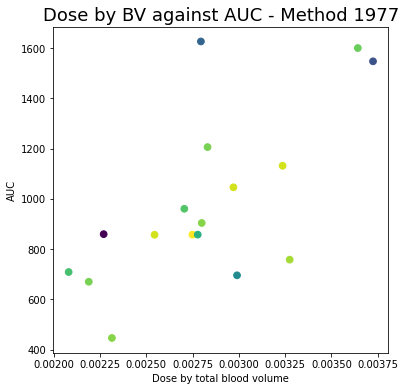

In [18]:
plt.rcParams["figure.figsize"]=(6, 6)
plt.scatter(df["Dose/bv"], df["auc"], s=45, c=df["Age"])
# plt.legend()
plt.title("Dose by BV against AUC - Method 1977", fontsize=18)
plt.xlabel("Dose by total blood volume")
plt.ylabel("AUC")

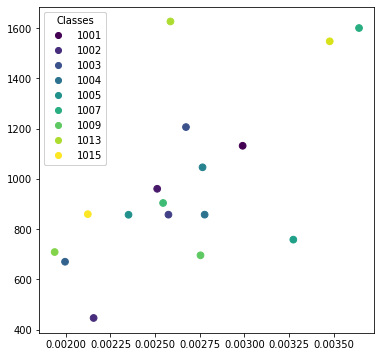

In [87]:

x, y = df["Dose/bv"], df["auc"]
c = range(17)

fig, ax = plt.subplots()

scatter = ax.scatter(x, y, c=c, s=45)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(handles = scatter.legend_elements()[0],
                    labels=list(df["ATLaS_ID"].values),
                    loc="upper left", title="Classes")
ax.add_artist(legend1)
# produce a legend with a cross-section of sizes from the scatter
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
# legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")

plt.show()

right lower 1020
upper outlier KT

In [40]:
df

,ATLaS_ID,Age,Sex,Dose,Height,Weight,Genotype,auc,feet,inch,meters,IBW,BV/kg,TBV,Dose/TBV,dw,ddw,bv,Dose/bv
0,1001,68.0,1.0,16.09,5'7'',81.646627,2.0,1131.903507,5,7,1.7018,63.714711,75.0,4778.603346,0.003367,65.781691,24.117556,5380.020652,0.002991
1,1002,59.0,1.0,14.36,5'10'',81.646627,2.0,960.628952,5,10,1.7780,69.548248,75.0,5216.118600,0.002753,72.681533,12.334761,5716.710067,0.002512
2,1003,63.0,1.0,12.86,6',81.646627,1.0,446.101610,6,0,1.8288,73.579208,75.0,5518.440576,0.002330,77.678968,5.107764,5965.628965,0.002156
3,1004,71.0,1.0,13.37,5'9'',65.770894,2.0,857.586570,5,9,1.7526,67.575349,75.0,5068.151154,0.002638,70.304706,-6.448804,5192.334001,0.002575
4,1005,62.0,1.0,13.50,5'10'',56.245454,2.0,1206.387196,5,10,1.7780,69.548248,75.0,5216.118600,0.002588,72.681533,-22.613831,5050.238550,0.002673
5,1007,62.0,1.0,14.86,6',131.541787,2.0,670.036776,6,0,1.8288,73.579208,75.0,5518.440576,0.002693,77.678968,69.340287,7446.586861,0.001996
6,1009,55.0,0.0,11.15,5'3'',55.338269,1.0,857.640765,5,3,1.6002,56.334081,65.0,3661.715257,0.003045,57.589896,-3.909761,4014.036572,0.002778
7,1013,68.0,1.0,15.49,5'10'',77.110703,1.0,1046.157348,5,10,1.7780,69.548248,75.0,5216.118600,0.002970,72.681533,6.093941,5600.109398,0.002766
8,1015,68.0,1.0,12.65,5'7'',81.646627,2.0,857.174085,5,7,1.7018,63.714711,75.0,4778.603346,0.002647,65.781691,24.117556,5380.020652,0.002351
9,1020,65.0,0.0,16.59,5'10'',69.853225,2.0,758.090942,5,10,1.7780,69.548248,65.0,4520.636120,0.003670,72.681533,-3.891371,5066.203472,0.003275


In [92]:
# correlation 
np.corrcoef(df.auc, df["Dose/bv"])

array([[1.        , 0.67189006],
       [0.67189006, 1.        ]])

In [55]:
np.corrcoef(df.auc, df["Dose"]/df["Weight"])

array([[1.       , 0.6131888],
       [0.6131888, 1.       ]])

### Linear regression

In [56]:
import statsmodels.api as sm

In [93]:
paralist = [
    #'NET dose (mCi), '
    "Sex",
    "Dose/bv"
]
Y_s = df.auc
X_s = df[paralist]
X_s = sm.add_constant(X_s)
model_s = sm.OLS(Y_s,X_s)
results_s = model_s.fit()
results_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    auc   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     6.528
Date:                Fri, 17 Mar 2023   Prob (F-statistic):            0.00993
Time:                        17:29:54   Log-Likelihood:                -117.13
No. Observations:                  17   AIC:                             240.3
Df Residuals:                      14   BIC:                             242.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -694.2224    519.211     -1.337      0.203   -1807.819     419.374
Sex          168.5559    183.695      0.918      0.374    -225.430     562.542
Dose/bv     5.466e+05   1.54e+05      3.556      0.003    2.17e+05    8.76e+05
==============================================================================
Omnibus:                        3.967   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.138   Jarque-Bera (JB):                1.740
Skew:                           0.633   Prob(JB):                        0.419
Kurtosis:                       3.924   Cond. No.                     3.19e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [97]:
paralist = [
    "Dose/bv"
]
Y_s = df.auc
X_s = df[paralist]
X_s = sm.add_constant(X_s)
model_s = sm.OLS(Y_s,X_s)
results_s = model_s.fit()
results_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    auc   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     12.34
Date:                Fri, 17 Mar 2023   Prob (F-statistic):            0.00314
Time:                        17:31:03   Log-Likelihood:                -117.62
No. Observations:                  17   AIC:                             239.2
Df Residuals:                      15   BIC:                             240.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -388.0902    395.734     -0.981      0.342   -1231.577     455.396
Dose/bv     4.872e+05   1.39e+05      3.513      0.003    1.92e+05    7.83e+05
==============================================================================
Omnibus:                        4.109   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.128   Jarque-Bera (JB):                1.811
Skew:                           0.537   Prob(JB):                        0.404
Kurtosis:                       4.184   Cond. No.                     2.19e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [94]:
# Best so far. Age + Dose/bv
paralist = [
    #'NET dose (mCi), '
    "Age",
    "Dose/bv"
]
Y_s = df.auc
X_s = df[paralist]
X_s = sm.add_constant(X_s)
model_s = sm.OLS(Y_s,X_s)
results_s = model_s.fit()
results_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    auc   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     8.072
Date:                Fri, 17 Mar 2023   Prob (F-statistic):            0.00466
Time:                        17:30:01   Log-Likelihood:                -116.21
No. Observations:                  17   AIC:                             238.4
Df Residuals:                      14   BIC:                             240.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         77.5718    477.017      0.163      0.873    -945.528    1100.672
Age           -8.1264      5.103     -1.593      0.134     -19.070       2.817
Dose/bv     4.877e+05   1.32e+05      3.693      0.002    2.04e+05    7.71e+05
==============================================================================
Omnibus:                        1.143   Durbin-Watson:                   2.316
Prob(Omnibus):                  0.565   Jarque-Bera (JB):                0.114
Skew:                           0.023   Prob(JB):                        0.945
Kurtosis:                       3.399   Cond. No.                     1.29e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [95]:
paralist = [
    "Weight",
    "Dose/bv"
]
Y_s = df.auc
X_s = df[paralist]
X_s = sm.add_constant(X_s)
model_s = sm.OLS(Y_s,X_s)
results_s = model_s.fit()
results_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    auc   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     5.797
Date:                Fri, 17 Mar 2023   Prob (F-statistic):             0.0147
Time:                        17:30:10   Log-Likelihood:                -117.60
No. Observations:                  17   AIC:                             241.2
Df Residuals:                      14   BIC:                             243.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -280.1942    678.905     -0.413      0.686   -1736.302    1175.913
Weight        -0.8040      4.037     -0.199      0.845      -9.463       7.855
Dose/bv     4.713e+05   1.64e+05      2.870      0.012    1.19e+05    8.23e+05
==============================================================================
Omnibus:                        4.383   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.112   Jarque-Bera (JB):                2.015
Skew:                           0.548   Prob(JB):                        0.365
Kurtosis:                       4.281   Cond. No.                     2.02e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [96]:
paralist = [
    "Dose",
    "Dose/bv"
]
Y_s = df.auc
X_s = df[paralist]
X_s = sm.add_constant(X_s)
model_s = sm.OLS(Y_s,X_s)
results_s = model_s.fit()
results_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    auc   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     5.784
Date:                Fri, 17 Mar 2023   Prob (F-statistic):             0.0148
Time:                        17:30:20   Log-Likelihood:                -117.61
No. Observations:                  17   AIC:                             241.2
Df Residuals:                      14   BIC:                             243.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -324.0102    569.403     -0.569      0.578   -1545.258     897.238
Dose          -8.7582     54.111     -0.162      0.874    -124.814     107.298
Dose/bv     5.083e+05   1.94e+05      2.620      0.020    9.23e+04    9.24e+05
==============================================================================
Omnibus:                        4.412   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                2.029
Skew:                           0.571   Prob(JB):                        0.363
Kurtosis:                       4.250   Cond. No.                     4.23e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.23e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

 men.      50 + (0.91 × [height in centimeters − 152.4]) 
 
 women as 45.5 + (0.91 × [height in centimeters − 152.4]

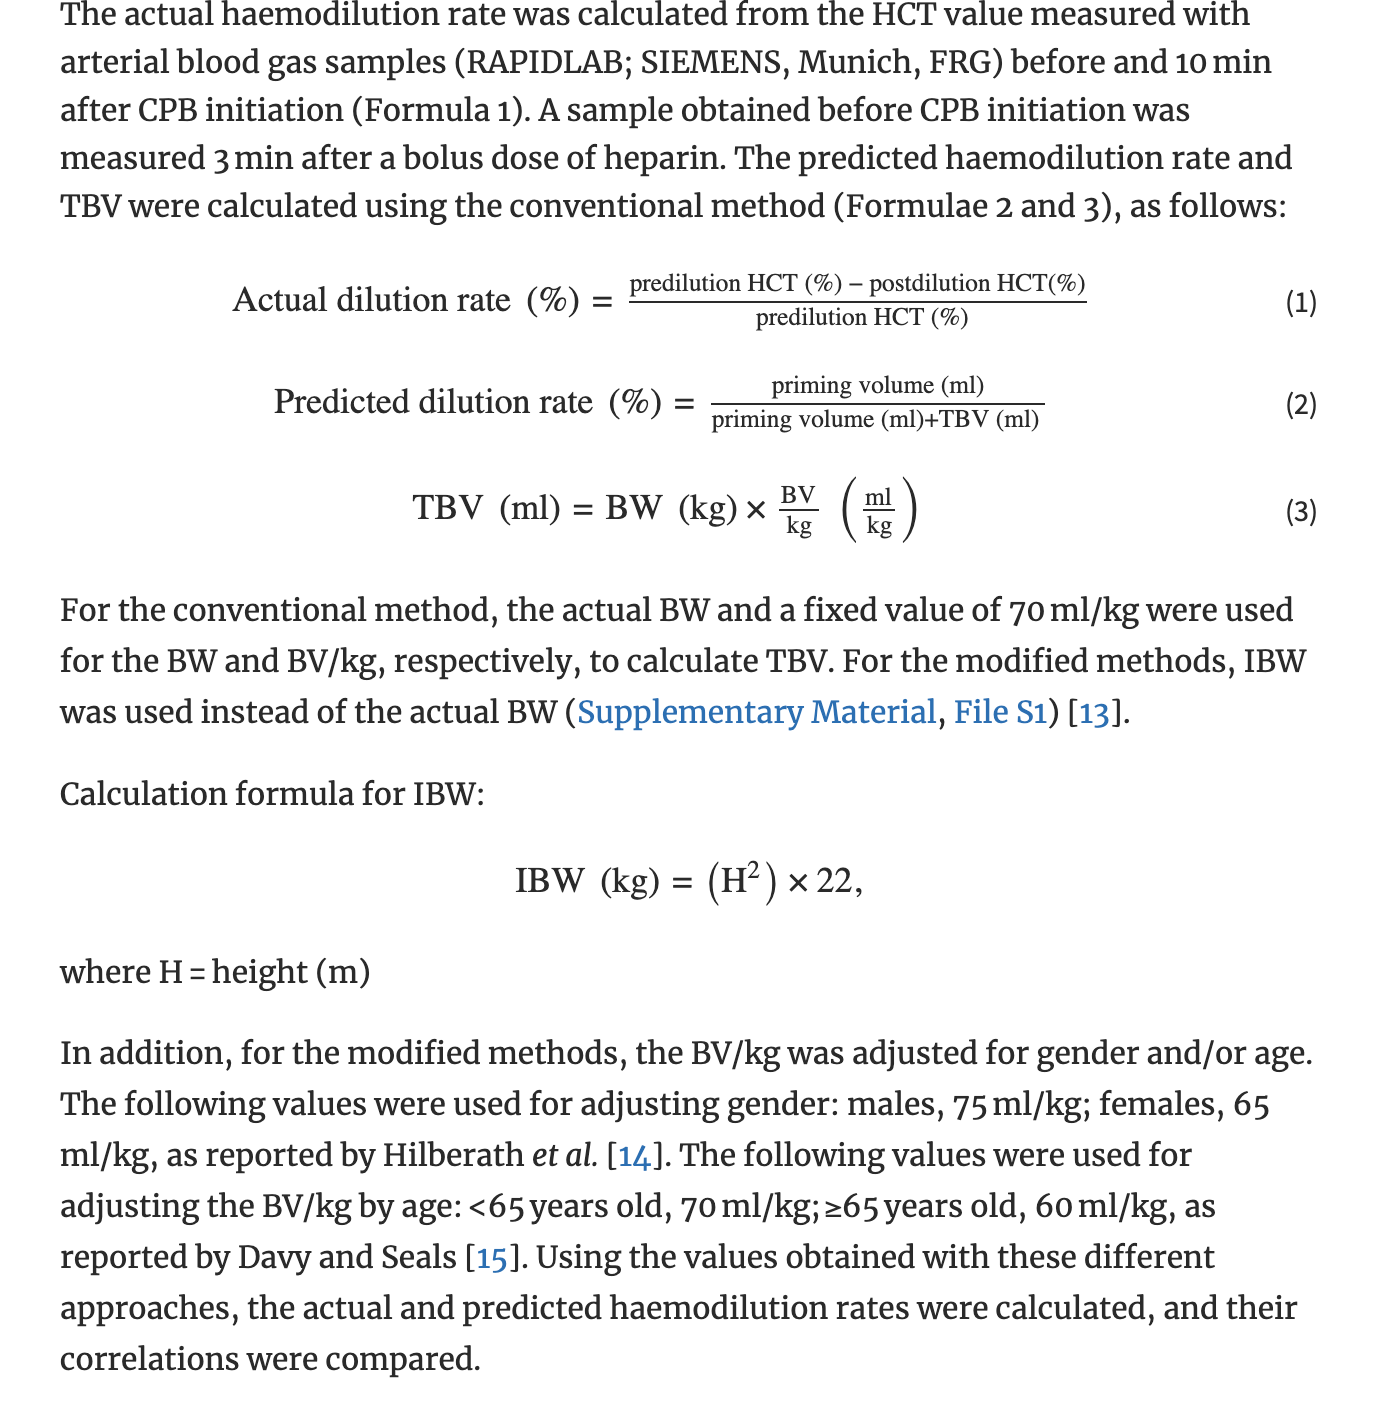

## Citation
@article{10.1093/icvts/ivy173,
    author = {Muraki, Ryosuke and Hiraoka, Arudo and Nagata, Kazuyuki and Nakajima, Kosuke and Oshita, Tomoya and Arimichi, Masahisa and Chikazawa, Genta and Yoshitaka, Hidenori and Sakaguchi, Taichi},
    title = "{Novel method for estimating the total blood volume: the importance of adjustment using the ideal body weight and age for the accurate prediction of haemodilution during cardiopulmonary bypass}",
    journal = {Interactive CardioVascular and Thoracic Surgery},
    volume = {27},
    number = {6},
    pages = {802-807},
    year = {2018},
    month = {06},
    abstract = "{Although total blood volume (TBV) is central to the estimation of the haemodilution rate during cardiopulmonary bypass (CPB), conventional formulas lack sufficient accuracy. The aim of this study was to establish a new formula using ideal body weight (BW) with adjustment for gender or age to estimate TBV for a more accurate prediction of the haemodilution rate during CPB.A total of 214 consecutive patients who underwent cardiac surgery with CPB were included in this study. TBV was retrospectively estimated using the following formulae: (1) Conventional TBV = actual BW × fixed 70 ml/kg, (2) gender-based modified TBV = ideal BW × 75 ml/kg (male) or 65 ml/kg (female) and (3) age-based modified TBV = ideal BW × 70 ml/kg (\\&lt;65 years old) or 60 ml/kg (≥65 years old). The relationship between actual and predicted haemodilution rates calculated by these formulas was examined.The actual haemodilution rate based on the haematocrit value was 24.4 ± 4.4\\%. There was no significant correlation between the actual and predicted haemodilution rates obtained by the conventional formula, whereas both modified formulae with the ideal BW showed a significant correlation. Furthermore, the age-based modified formula showed the highest correlation level (r = 0.45, P \\&lt; 0.001) as well as a strong correlation between the actual and predicted postdilution haematocrit values (y = 0.903x + 3.385, R2 = 0.892).The conventional formula is unable to predict the actual haemodilution rate accurately. Our new formula with a combination of the ideal BW and adjustment for age was shown to be useful for the accurate prediction of the haemodilution rate during CPB.}",
    issn = {1569-9285},
    doi = {10.1093/icvts/ivy173},
    url = {https://doi.org/10.1093/icvts/ivy173},
    eprint = {https://academic.oup.com/icvts/article-pdf/27/6/802/27075697/ivy173.pdf},
}



In [20]:
bv

45.751807535636

Weight-based estimate of blood volume was determined using the equation developed by Feldschuh and Enson.7 It uses gender, height, weight, and deviation from desired weight to calculate blood volume as follows: Blood Volume (mL) = [Blood Volume to Body Weight Ratio (mL/kg)] [body weight (kg)]= 45.2 + 25.3 exp(-0.0198 × DDW). DDW is Deviation from Desirable Weight (%) = 100 [body weight (kg) - DW (kg)] / [DW (kg)]. DW is Desirable Weight (kg) for women = 7.090 exp[0.01309*(body height (cm))].7m

In [11]:
# new_df = aif_new.drop(columns=["ATLaS_ID"]).astype(np.float).copy()
# new_df.loc[:,"sqrt_dose"] = np.sqrt(new_df[["NET dose (mCi)"]])
# new_df.loc[:,"lambda"] = new_df['sqrt_dose'].div(new_df['Weight (Kgs)'])
# new_df["dose_by_age"] = new_df['NET dose (mCi)']/new_df['Age']
# new_df["weight_by_age"] = new_df['Weight (Kgs)']/new_df["Age"]
# new_df.Sex = 2*(new_df.Sex-0.5)
# new_df.Genotype = (new_df.Genotype-1.5)*2
# new_df["asg"] = new_df.Age * new_df.Sex * new_df.Genotype

# new_df["dose_2"] = new_df['NET dose (mCi)']**2
# new_df["weight_2"] = new_df['Weight (Kgs)']**2
# new_df["sqrt_weight"] = new_df['Weight (Kgs)']**0.5
# new_df["lambda_0.5"] = new_df['lambda'] ** 0.5
# new_df["weight_-1"] = new_df['Weight (Kgs)']**(-1)
# new_df["dose_m_weight"] = new_df['Weight (Kgs)']*new_df['NET dose (mCi)']

# new_df.loc[:,"ID"] = subjs
# # new_df.loc[:, "peaks"] = peaks
# new_df.loc[:, "auc"] = auc[1:].values